## Expirements
* MASE
  - KMeansClustering
  
## Determine number clusters per bundle based on population data

**NOTE `662551` not in `HCP_1200`**

```
s3://profile-hcp-west/hcp_reliability/single_shell/hcp_1200_afq/
s3://profile-hcp-west/hcp_reliability/single_shell/hcp_1200_afq_CSD/
```

In [1]:
experiment_name = ['MASE_ChooseK_Study_FA_and_MD']
subjects = [
    '103818', '105923', '111312', '114823', '115320',
    '122317', '125525', '130518', '135528', '137128',
    '139839', '143325', '144226', '146129', '149337',
    '149741', '151526', '158035', '169343', '172332',
    '175439', '177746', '185442', '187547', '192439',
    '194140', '195041', '200109', '200614', '204521',
    '250427', '287248', '341834', '433839', '562345',
    '599671', '601127', '627549', '660951', # '662551', 
    '783462', '859671', '861456', '877168', '917255'
]
# session_names = ['HCP_1200', 'HCP_Retest']
session_names = ['HCP_1200']
# bundle_names = ['SLF_L']
# bundle_names = ['SLF_L', 'SLF_R']
bundle_names = ['SLF_L', 'SLF_R', 'ARC_L', 'ARC_R', 'CST_L', 'CST_R']
# n_clusters = [2, 3, 4]
# n_clusters = range(2,10)
n_clusters = [9]

In [2]:
import itertools
# args = list(itertools.product(subjects, session_names, bundle_names))
args = list(itertools.product(experiment_name, subjects, session_names, bundle_names, n_clusters))

In [ ]:
args = args[:len(n_clusters)]

In [3]:
args

[('MASE_ChooseK_Study_FA_and_MD', '103818', 'HCP_1200', 'SLF_L', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '103818', 'HCP_1200', 'SLF_R', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '103818', 'HCP_1200', 'ARC_L', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '103818', 'HCP_1200', 'ARC_R', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '103818', 'HCP_1200', 'CST_L', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '103818', 'HCP_1200', 'CST_R', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '105923', 'HCP_1200', 'SLF_L', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '105923', 'HCP_1200', 'SLF_R', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '105923', 'HCP_1200', 'ARC_L', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '105923', 'HCP_1200', 'ARC_R', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '105923', 'HCP_1200', 'CST_L', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '105923', 'HCP_1200', 'CST_R', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '111312', 'HCP_1200', 'SLF_L', 9),
 ('MASE_ChooseK_Study_FA_and_MD', '111312', 'HCP_1200', 'SLF_R', 9),
 ('MASE_ChooseK_Study_FA_and_MD', 

useful for when individual jobs fail

all-in-one: `subbundle3`, `subbundle4`, and `subbundle5`

**Multiple Adjacency Spectral Emdedding (MASE)** 

- UNWARPED **FA Coefficient of Determination (FA R2)** 

- **Inverse Scaled Minimum average Direct-Flip (IS MDF) distance**

In [4]:
def subbundle(experiment_name, subject, session, bundle_name, n_clusters, clean_bundles=True):
    """
    Run clustering for K=`n_clusters` on `subject`, `session`, `bundle_name` 
    using `clean_bundles` CSD tractography
    
    Features:
    - Tissue - Fractional Anisotropy Coefficient of Determination (FA R^2) 
    - Distance - Inverse Scaled Minimum average Direct-Flip distance (IS_MDF)
    
    Generates:
    - Adjacencey and the corresponding Laplacian matricies for each feature
      - Joint graph embeddings using `MASE`/`OMNI` both feature matricies
        - Clusters using both `KMeansCluster`/`GassianCluster` for each graph embedding
    """
    import time
    import s3fs
    import numpy as np
    import pandas as pd
    from dipy.io.streamline import load_tractogram, save_tractogram
    from dipy.io.stateful_tractogram import StatefulTractogram
    from dipy.io.utils import create_nifti_header, get_reference_info
    from dipy.tracking.streamline import set_number_of_points, values_from_volume, bundles_distances_mdf
    import dipy.tracking.utils as dtu
    import nibabel as nib
    from graspologic.embed import MultipleASE as MASE
    from graspologic.cluster import KMeansCluster, GaussianCluster
    from graspologic.plot import pairplot
    from seaborn import lineplot
    import matplotlib.pyplot as plt
    
    def coeff_of_determination(data, model, axis=-1):
        """
         http://en.wikipedia.org/wiki/Coefficient_of_determination
                  _                                            _
                 |    sum of the squared residuals              |
        R^2 =    |1 - ---------------------------------------   | * 100
                 |_    sum of the squared mean-subtracted data _|
        """
        X = np.empty((data.shape[0], model.shape[0]))
        demeaned_data = data - np.mean(data, axis=axis)[...,np.newaxis]
        ss_tot = np.sum(demeaned_data **2, axis=axis)
        # Don't divide by 0:
        if np.all(ss_tot==0.0):
            X[:, :] = np.nan
            return X
        for ii in range(X.shape[0]):
            for jj in range(X.shape[1]):
                # There's no point in doing any of this: 
                if np.all(data[ii]==0.0) and np.all(model[ii]==0.0):
                    X[ii, jj] = np.nan
                else:
                    residuals = data[ii] - model[jj]
                    ss_err = np.sum(residuals ** 2, axis=axis)
                    X[ii, jj] = 1 - (ss_err/ss_tot[ii])
        return X

    def rrss(y, yhat):        
        residuals = y - yhat
        rss = np.dot(residuals.T, residuals)
        rrss = np.sqrt(rss)
        
        return rrss

    def relabel_clusters(cluster_labels):
        from_values = np.flip(np.argsort(np.bincount(cluster_labels))[-(np.unique(cluster_labels).size):])
        to_values = np.arange(from_values.size)

        d = dict(zip(from_values, to_values))

        new_cluster_labels = np.copy(cluster_labels)

        for k, v in d.items():
            new_cluster_labels[cluster_labels == k] = v

        return new_cluster_labels
        
    def density_map(tractogram):
        affine, vol_dims, voxel_sizes, voxel_order = get_reference_info(tractogram)
        tractogram_density = dtu.density_map(tractogram.streamlines, np.eye(4), vol_dims)
        tractogram_density = np.uint8(tractogram_density)
        nifti_header = create_nifti_header(affine, vol_dims, voxel_sizes)
        density_map_img = nib.Nifti1Image(tractogram_density, affine, nifti_header)
        
        return density_map_img
        
    def save_cluster_tractograms_and_density_maps(bundle_tractogram, model_prefix, cluster_labels):        
        for cluster_label in np.unique(cluster_labels):
            # tractogram
            f_name = f'{model_prefix}_cluster_{cluster_label}.trk'
            cluster_indicies = np.array(np.where(cluster_labels == cluster_label)[0])
            tg = StatefulTractogram.from_sft(bundle_tractogram.streamlines[cluster_indicies], bundle_tractogram)
            save_tractogram(tg, f_name, bbox_valid_check=False)
            print('saving cluster tractogram:', f_name)
            
            # density map -- 8-bit unsigned int and gz
            f_name = f'{model_prefix}_cluster_{cluster_label}_density_map.nii.gz'
            tg.to_vox()
            nib.save(density_map(tg), f_name)
            print('saving cluster density map:', f_name)
            
            # TODO save cluster afq_profile
            
    def cluster(clusterer, embedding, model_prefix):
        idx = clusterer.fit_predict(embedding)
        # sort cluster by size, for convience, 
        # will need to resort by cross-subject similarity
        idx = relabel_clusters(idx)
        f_name = f'{model_prefix}_idx.npy'
        np.save(f_name, idx)
        print('saving:', f_name)
        return idx
            
    def run_cluster_algos(tractogram, embedder_name, embedding, embedding_name):
        # KMeans
        kmeans_model_prefix = f'{embedder_name}_kmeans_{embedding_name}'
        kmeans_clusterer = KMeansCluster(n_clusters)
        kmeans_idx = cluster(kmeans_clusterer, embedding, kmeans_model_prefix)
        
        kmeans_info = pd.DataFrame(data={
            'subject': [subject], 
            'session': [session], 
            'bundle': [bundle_name], 
            'algorithm': ['kmeans'], 
            'embed dimensions': [embedding.shape], 
            'max n_clusters' : [n_clusters], 
            'n_clusters selected': [kmeans_clusterer.n_clusters_], 
            'labels': [np.unique(kmeans_idx)], 
            'scores': [kmeans_clusterer.silhouette_]
        })
        kmeans_info.to_pickle(f'{kmeans_model_prefix}_info.pkl')
        print('saving:', f'{kmeans_model_prefix}_info.pkl')
        
        # save silhouette scores so can use to determine n_clusters for population
        print(f'{embedder_name} kmeans silhoutte\n', kmeans_clusterer.silhouette_)
        np.save(f'{kmeans_model_prefix}_silhouette_scores.npy', kmeans_clusterer.silhouette_)
        print('saving:', f'{kmeans_model_prefix}_silhouette_scores.npy')
        
        lineplot(data=kmeans_clusterer.silhouette_).set(
            title=f'{subject} {session} {bundle_name}\nkmeans n_clusters: {n_clusters} silhoutte scores',
            xticks=range(len(range(2,n_clusters+1))),
            xticklabels=range(2,n_clusters+1)
        )
        plt.savefig(f'{kmeans_model_prefix}_silhouette_scores.png')
        print('saving:', f'{kmeans_model_prefix}_silhouette_scores.png')
        
        plt.clf()
        pairplot(embedding, kmeans_idx, font_scale=0.55,
                 title=f'{subject} {session} {bundle_name}\nkmeans n_clusters: {n_clusters}')
        plt.savefig(f'{kmeans_model_prefix}_pairplot.png')
        print('saving:', f'{kmeans_model_prefix}_pairplot.png')
        
        save_cluster_tractograms_and_density_maps(tractogram, kmeans_model_prefix, kmeans_idx)
        
    def run_embeddings(tractogram, features, feature_name):
        ### multiple adjacency spectral embedding (mase) ###
        print('mase')
        tic = time.perf_counter()

        embedder = MASE()
        embedder_name = 'mase'
        embedding = embedder.fit_transform(features)
        print(embedder_name, feature_name, 'embedding dimension', embedding.shape)
        run_cluster_algos(tractogram, embedder_name, embedding, feature_name)

        toc = time.perf_counter()
        print(f'mase {toc - tic:0.4f} seconds')

    print("begin", subject, session, bundle_name, n_clusters)
    
    fs = s3fs.S3FileSystem()
    
    ### fractional anisotropy scalar file ###
    fa_scalar_filename = 'FA.nii.gz'
    print('loading FA scalar file:', fa_scalar_filename)
    tic = time.perf_counter()
    
    fs.get(
        (
            f'profile-hcp-west/hcp_reliability/single_shell/'
            f'{session.lower()}_afq_CSD/sub-{subject}/ses-01/'
            f'sub-{subject}_dwi_model-DTI_FA.nii.gz'
        ),
        f'{fa_scalar_filename}'
    )
    
    fa_scalar_data = nib.load(fa_scalar_filename).get_fdata()
    toc = time.perf_counter()
    print(f'scalar file: {toc - tic:0.4f} seconds')
    
    ### mean diffusivity scalar file ###
    md_scalar_filename = 'MD.nii.gz'
    print('loading scalar file: ', md_scalar_filename)
    tic = time.perf_counter()
    
    fs.get(
        (
            f'profile-hcp-west/hcp_reliability/single_shell/'
            f'{session.lower()}_afq_CSD/sub-{subject}/ses-01/'
            f'sub-{subject}_dwi_model-DTI_MD.nii.gz'
        ),
        f'{md_scalar_filename}'
    )
    
    md_scalar_data = nib.load(md_scalar_filename).get_fdata()
    toc = time.perf_counter()
    print(f'scalar file: {toc - tic:0.4f} seconds')
    
    ### single shell deterministic bundle tractography ###
    tractogram_filename = f'{bundle_name}.trk'
    print('loading tractogram:', tractogram_filename)
    tic = time.perf_counter()

    bundle_folder = 'bundles'
    
    if clean_bundles:
        bundle_folder = 'clean_' + bundle_folder
        
    fs.get(
        (
            f'profile-hcp-west/hcp_reliability/single_shell/'
            f'{session.lower()}_afq_CSD/sub-{subject}/ses-01/'
            f'{bundle_folder}/sub-{subject}_dwi_space-RASMM_model-CSD_desc-det-afq-{bundle_name}_tractography.trk'
        ),
        f'{tractogram_filename}'
    )
    
    tractogram = load_tractogram(tractogram_filename, 'same')
    toc = time.perf_counter()
    print(f'tractogram file: {toc - tic:0.4f} seconds')
    
    ### streamline profiles ###
    print('calculating streamline profiles')
    tic = time.perf_counter()
    n_points = 100
    
    fgarray = set_number_of_points(tractogram.streamlines, n_points)
    
    if len(fgarray) == 0:
        return
    
    # FA Values
    fa_values = np.array(values_from_volume(fa_scalar_data, fgarray, tractogram.affine))
    f_name = 'streamline_profile_fa.npy'
    np.save(f_name, fa_values)
    print('saving:', f_name)
    toc = time.perf_counter()

    print('fa values:', fa_values.shape)
    
    # MD Values
    md_values = np.array(values_from_volume(md_scalar_data, fgarray, tractogram.affine))
    f_name = 'streamline_profile_md.npy'
    np.save(f_name, md_values)
    print('saving: ', f_name)
    toc = time.perf_counter()

    print('md values:', md_values.shape)
    
    print(f'streamline profile: {toc - tic:0.4f} seconds')
    
    ### Inverse Scaled MDF (Minimum average Direct-Flip) ###
    print('calculating mdf')
    tic = time.perf_counter()
    mdf = bundles_distances_mdf(fgarray, fgarray)
    
    # enforce symmetry
    mdf = (mdf + mdf.T) / 2
    
    # inverse scale
    is_mdf = (mdf.max() - mdf)
    is_mdf = is_mdf / is_mdf.max()

    f_name = 'adjacency_is_mdf.npy'
    np.save(f_name, is_mdf)
    print('saving:', f_name)
    toc = time.perf_counter()
    
    print('is_mdf:', is_mdf.shape)
    print(f'mdf {toc - tic:0.4f} seconds')
    
    ### streamline r2 ###
    print('calculating streamline r2')
    tic = time.perf_counter()
    
    # calculate FA R2
    fa_r2 = coeff_of_determination(fa_values, fa_values)
    
    # enforce symmetry
    fa_r2 += fa_r2.T
    fa_r2 = fa_r2/2
    
    # save file
    f_name = 'adjacency_fa_r2.npy'
    np.save(f_name, fa_r2)
    print('saving:', f_name)
    
    print('adjacency_fa_r2:', fa_r2.shape)
    
    # calculate MD R2
    md_r2 = coeff_of_determination(md_values, md_values)
    
    # enforce symmetry
    md_r2 += md_r2.T
    md_r2 = md_r2/2
    
    # save file
    f_name = 'adjacency_md_r2.npy'
    np.save(f_name, md_r2)
    print('saving: ', f_name)
    
    print('adjacency_md_r2:', md_r2.shape)
    
    toc = time.perf_counter()
    
    print(f'streamline r2: {toc - tic:0.4f} seconds')
    
    ### clustering ###
    
    fa_tissue = np.load('adjacency_fa_r2.npy')
    md_tissue = np.load('adjacency_md_r2.npy')
    distance = np.load('adjacency_is_mdf.npy')
    features = [fa_tissue, md_tissue, distance]
    feature_name = 'fa_r2_md_r2_is_mdf'
    run_embeddings(tractogram, features, feature_name)
    
    ### upload everything to s3 ###
    fs.put('*.npy', f'hcp-subbundle/{experiment_name}/{session}/{bundle_name}/{subject}/{n_clusters}')
    fs.put('*.nii.gz', f'hcp-subbundle/{experiment_name}/{session}/{bundle_name}/{subject}/{n_clusters}')
    fs.put('*.trk', f'hcp-subbundle/{experiment_name}/{session}/{bundle_name}/{subject}/{n_clusters}')
    fs.put('*.pkl', f'hcp-subbundle/{experiment_name}/{session}/{bundle_name}/{subject}/{n_clusters}')
    fs.put('*.png', f'hcp-subbundle/{experiment_name}/{session}/{bundle_name}/{subject}/{n_clusters}')
    
    print("end", subject, session, bundle_name, n_clusters)

test locally before running on AWS

begin 103818 HCP_1200 SLF_L 9
loading FA scalar file: FA.nii.gz
scalar file: 0.8757 seconds
loading scalar file:  MD.nii.gz
scalar file: 0.6138 seconds
loading tractogram: SLF_L.trk
tractogram file: 0.8902 seconds
calculating streamline profiles
saving: streamline_profile_fa.npy
fa values: (1245, 100)
saving:  streamline_profile_md.npy
md values: (1245, 100)
streamline profile: 0.2825 seconds
calculating mdf
saving: adjacency_is_mdf.npy
is_mdf: (1245, 1245)
mdf 1.8339 seconds
calculating streamline r2
saving: adjacency_fa_r2.npy
adjacency_fa_r2: (1245, 1245)
saving:  adjacency_md_r2.npy
adjacency_md_r2: (1245, 1245)
streamline r2: 42.5178 seconds
mase
mase fa_r2_md_r2_is_mdf embedding dimension (1245, 3)
saving: mase_kmeans_fa_r2_md_r2_is_mdf_idx.npy
saving: mase_kmeans_fa_r2_md_r2_is_mdf_info.pkl
mase kmeans silhoutte
 [0.3720302928051627, 0.3841101767735029, 0.39509958409034523, 0.39973283870231885, 0.38799373653895736, 0.3682481994248161, 0.37301509441822006, 0.36332204213478364]
sa

<Figure size 432x288 with 0 Axes>

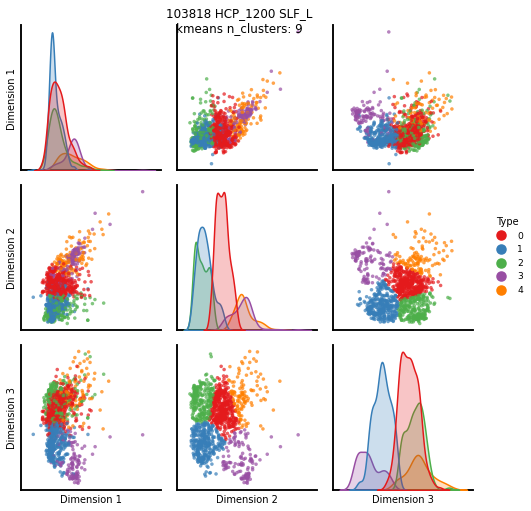

In [6]:
subbundle(experiment_name[0], subjects[0], session_names[0], bundle_names[0], n_clusters[0])

In [7]:
import cloudknot as ck
ck.set_region('us-west-2')

In [ ]:
from datetime import datetime
knot = ck.Knot(
    name='hcp-subbundle-' + datetime.now().isoformat()[:-7].replace(':','-'),
    func=subbundle,
    base_image='python:3.8',
    pars_policies=('AmazonS3FullAccess',),
    memory=32000,  # in MB
    volume_size=50,  # in GB
    bid_percentage=105)

Reconnect to existing knot

Reuse existing Docker Image

In [ ]:
# run subset as trial
# result_futures = knot.map(args[:4], starmap=True)

# run all
result_futures = knot.map(args, starmap=True)

# rerun failed
# result_futures = knot.map(rerun_targets(), starmap=True)

In [ ]:
knot.view_jobs()

In [ ]:
knot.jobs[0].status

delete everything associate to the knot

In [ ]:
knot.clobber(clobber_pars=True, clobber_repo=True, clobber_image=True)